# Architektur Neuronales Netz, Output x_H2 und x_NH3

In [1]:
# aNN Architektur

# Importe / Bibliotheken
import torch
from torch import nn
from torch.nn.functional import normalize as norm
from torch import log10
from torch.utils.data import TensorDataset, DataLoader, random_split
from torch.optim.lr_scheduler import StepLR, MultiStepLR, ReduceLROnPlateau
from sklearn.metrics import r2_score as r2
from sklearn.metrics import max_error
# from sklearn.metrics import mean_squared_error as MSE
# from sklearn.metrics import mean_absolute_error as MAE
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

#### Default Datentyp

In [2]:
torch.set_default_dtype(torch.float64)

#### Erzeugnung des Moduls

In [3]:
class NeuralNetwork(nn.Module):
    
    #Initalisierung der Netzwerk layers
    def __init__(self, input_size, hidden1_size, hidden2_size, output_size):
    
        super().__init__() #Referenz zur Base Class (nn.Module)
        #Kaskade der Layer
        self.linear_afunc_stack = nn.Sequential(
            #nn.BatchNorm1d(input_size), # Normalisierung, damit Inputdaten gleiche Größenordnung haben
            nn.Linear(input_size, hidden1_size), #Lineare Transformation mit gespeicherten weights und biases
            nn.Tanh(), #Nicht lineare Aktivierungsfunktion um komplexe nichtlineare Zusammenhänge abzubilden
            #nn.SELU(),
            nn.Linear(hidden1_size, hidden2_size),
            nn.Tanh(),
            #nn.SELU(),
            nn.Linear(hidden2_size, output_size),
        )

    #Implementierung der Operationen auf Input Daten
    def forward(self, x):
        out = self.linear_afunc_stack(x)
        return out

#### Ausgabe Modul

In [4]:
model = NeuralNetwork(5, 200, 200, 2)
print(model)

NeuralNetwork(
  (linear_afunc_stack): Sequential(
    (0): Linear(in_features=5, out_features=200, bias=True)
    (1): Tanh()
    (2): Linear(in_features=200, out_features=200, bias=True)
    (3): Tanh()
    (4): Linear(in_features=200, out_features=2, bias=True)
  )
)


#### DataLoader

In [5]:
batch_size = 64 #Zahl der Datenpaare die vor einem erneuten Update der Parameter ins Netzt gegeben werden
eq_data_file = Path.cwd() / 'data' / 'eq_dataset_x.npz' #Import der GGW Daten

res = np.load(eq_data_file)

# Bei Speicherung wurden Daten als T, p, x_0 und xi gespeichert
# Inputs T, p, x_0[H2,N2,NH3]
# Outputs x[H2,N2,NH3]
# Umwandlen der np.arrays in torch.tensors zur besseren Arbeit mit PyTorch
T = torch.tensor(res['T'])
p = torch.tensor(res['p'])
x_0 = torch.tensor(res['x_0'])
x = torch.tensor(res['x'])

#Anpassen der Daten auf gleiche Größenordnung
#T = log10(T)
# T = T / 850
# p = p / 1000


# print(T.dtype)
# print(xi.dtype)

x_input = torch.stack((T, p ,x_0[:,0],x_0[:,1],x_0[:,2]),1)
y_output = torch.stack((x[:,0], x[:,2]), 1) # [H2, NH3], dritter Stoffmengenanteil ergibt sich den anderen
#print(x_input.size())
# print(xi.size())

# Split des Datensatzes in Trainings und Testdaten
split = 0.8 # Anteil Trainingsdaten

x_input_train = x_input[:int(split * len(x_input)), :]
y_output_train = y_output[:int(split * len(y_output)), :]
x_input_test = x_input[int(split * len(x_input)):, :]
y_output_test = y_output[int(split * len(y_output)):, :]

# Preprocessing Normalisierung der Daten
mean_in = torch.mean(x_input_train,0) # Mittelwert
std_in = torch.std(x_input_train,0) # Standardabweichung
mean_out = torch.mean(y_output_train,0)
std_out = torch.std(y_output_train,0)

x_input_train_norm = (x_input_train - mean_in) / std_in
y_output_train_norm = (y_output_train - mean_out) / std_out

x_input_test_norm = (x_input_test - mean_in) / std_in
y_output_test_norm = (y_output_test - mean_out) / std_out

# print(x_input_train_norm)
# print(torch.mean(x_input_train_norm[:,0]))

# Tensoren zu einem großen Set gruppieren
train_dataset = TensorDataset(x_input_train_norm, y_output_train_norm)
test_dataset = TensorDataset(x_input_test_norm, y_output_test_norm)
    
# # Split in Trainings und Test Set
# train_dataset, test_dataset = random_split(dataset, 
#                                            [int(0.8*len(dataset)), int(0.2*len(dataset))], # splitting 80/20
#                                            generator = torch.Generator().manual_seed(42)) # Festlegung seed zur Reproduktivität

# Erzeugen der DataLoader zur Arbeit mit Daten
train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True) # shuffle batches zur Reduzierung von overfitting
test_dataloader = DataLoader(test_dataset, batch_size = batch_size, shuffle=False)


#### Generierung Netzwerk, Festlegung von loss Funktion und Optimizer

In [6]:
# Erzeugung aNN
net = NeuralNetwork(5, 200, 200, 2)

# Loss Funktion; gibt Fehler an
#loss_fn = nn.MSELoss()
loss_fn = nn.L1Loss()

#Definition custom loss Funktion, MRE
def MRELoss(outputs, targets):
    
    loss = torch.mean(abs((outputs - targets) / targets))
    
    return loss
    

#Optimizer
learning_rate = 1e-2
optimizer = torch.optim.Adam(net.parameters(), lr = learning_rate)
#scheduler = StepLR(optimizer, step_size = 30, gamma = 0.1)
#scheduler = MultiStepLR(optimizer, milestones=[30, 70, 100], gamma = 0.1)
scheduler = ReduceLROnPlateau(optimizer, factor = 0.1, patience = 10, threshold = 1e-4)

In [7]:
# learning_rate = 1e-6
# optimizer = torch.optim.Adam(net.parameters(), lr = learning_rate, )

#### Funktion zur Bestimmung der Genauigkeit

In [8]:
def check_accuracy(loader, net):
    
    loss = 0
    MRE = 0
    MAE = 0
    train_correct = 0
    train_total = len(loader.dataset)
    num_batches = len(loader) 
    #train_total = 0
    
    net.eval() # Put network in evaluation mode
    
    if loader == train_dataloader:
        dataset = "Train"
    else:
        dataset = "Test"
    
    with torch.no_grad():
        for X, y in loader:
            pred = net(X)
           
            #loss += MRELoss(pred, y).item()
            loss += loss_fn(pred, y) # Calculate the loss
            MRE += MRELoss(pred * std_out + mean_out, y * std_out + mean_out)
            MAE += loss_fn(pred * std_out + mean_out, y * std_out + mean_out)
            
            # Record the correct predictions for training data
            #_, predictions = torch.max(pred.data, 1)
            for i in range(len(pred)):
                if ((pred[i,0] * std_out[0] + mean_out[0]) - (y[i,0] * std_out[0] + mean_out[0]) and (pred[i,1] * std_out[1] + mean_out[1]) - (y[i,1] * std_out[1] + mean_out[1])) <= 0.01:
                    train_correct += 1
            #train_correct += (abs(pred.argmax(1) - y) <= 0.01).sum().item()
            #train_correct += (abs(predictions - y.data) <= 0.01).sum()
            #train_total += predictions.size(0)
            
        # Genauigkeit berechnen
        acc = float(train_correct) / float(train_total) * 100
        acc = round(acc, 2)
        
        loss /= num_batches
        MRE /= num_batches
        MAE /= num_batches

        print(f"{dataset} Error: \n Accuracy: {acc}%, Avg loss: {loss:>8f}, MRE: {MRE:>8f}, MAE: {MAE:>8f} \n")

    net.train()
    
    return acc, loss, MRE, MAE

#### Training

In [9]:
num_epochs = 200 #Iterationen über Datenset

train_loss = []
test_loss = []
train_accuracy = []
test_accuracy = []
train_MRE = []
test_MRE = []
train_MAE = []
test_MAE = []

#Optimierungsloop
for epoch in range(num_epochs):
#     train_correct = 0
#     train_total = 0
        
    for batch, (X,y) in enumerate(train_dataloader):
        
#         print(X.shape)
#         print(X.dtype)
        
        net.train() #Trainingmodus
        
        # forward
        pred = net(X)  # Do the forward pass
        loss = loss_fn(pred, y) # Calculate the loss
        #loss = MRELoss(pred, y)
        
        # backward
        optimizer.zero_grad() # Clear off the gradients from any past operation
        loss.backward()       # Calculate the gradients with help of back propagation, updating weights and biases
        
        # adam step gradient descent
        optimizer.step()      # Ask the optimizer to adjust the parameters based on the gradients  

        print ('Epoch %d/%d, Iteration %d/%d, Loss: %.4f' 
               %(epoch+1, num_epochs, batch+1, len(train_dataset)//batch_size, loss.item()))
        
    
    #scheduler.step() # Reduzieren Learning Rate (falls step size erreicht)
    net.eval() # Put the network into evaluation mode
    
    # Book keeping    
    # What was our train accuracy?
    tr_acc, tr_loss, tr_MRE, tr_MAE = check_accuracy(train_dataloader, net)
    
    #Record loss and accuracy
    train_accuracy.append(tr_acc)
    train_loss.append(tr_loss)
    train_MRE.append(tr_MRE)
    train_MAE.append(tr_MAE)
    
    scheduler.step(tr_loss) # LR scheduler step für reduceonPlateau
    
    # How did we do on the test set (the unseen set)
    # Record the correct predictions for test data
    t_acc, t_loss, t_MRE, t_MAE = check_accuracy(test_dataloader, net)
    test_accuracy.append(t_acc)
    test_loss.append(t_loss)
    test_MRE.append(t_MRE)
    test_MAE.append(t_MAE)

Epoch 1/200, Iteration 1/12, Loss: 0.8103
Epoch 1/200, Iteration 2/12, Loss: 1.0251
Epoch 1/200, Iteration 3/12, Loss: 0.6367
Epoch 1/200, Iteration 4/12, Loss: 0.6270
Epoch 1/200, Iteration 5/12, Loss: 0.5348
Epoch 1/200, Iteration 6/12, Loss: 0.6046
Epoch 1/200, Iteration 7/12, Loss: 0.4667
Epoch 1/200, Iteration 8/12, Loss: 0.4329
Epoch 1/200, Iteration 9/12, Loss: 0.3721
Epoch 1/200, Iteration 10/12, Loss: 0.2865
Epoch 1/200, Iteration 11/12, Loss: 0.2616
Epoch 1/200, Iteration 12/12, Loss: 0.3381
Epoch 1/200, Iteration 13/12, Loss: 0.3248
Train Error: 
 Accuracy: 63.5%, Avg loss: 0.328968, MRE: 0.241704, MAE: 0.043049 

Test Error: 
 Accuracy: 66.0%, Avg loss: 0.358809, MRE: 0.256472, MAE: 0.045686 

Epoch 2/200, Iteration 1/12, Loss: 0.3759
Epoch 2/200, Iteration 2/12, Loss: 0.2425
Epoch 2/200, Iteration 3/12, Loss: 0.2433
Epoch 2/200, Iteration 4/12, Loss: 0.2472
Epoch 2/200, Iteration 5/12, Loss: 0.3053
Epoch 2/200, Iteration 6/12, Loss: 0.3048
Epoch 2/200, Iteration 7/12, Loss

Train Error: 
 Accuracy: 82.5%, Avg loss: 0.073547, MRE: 0.055822, MAE: 0.009986 

Test Error: 
 Accuracy: 83.5%, Avg loss: 0.072184, MRE: 0.047106, MAE: 0.009970 

Epoch 13/200, Iteration 1/12, Loss: 0.0695
Epoch 13/200, Iteration 2/12, Loss: 0.1083
Epoch 13/200, Iteration 3/12, Loss: 0.0626
Epoch 13/200, Iteration 4/12, Loss: 0.1415
Epoch 13/200, Iteration 5/12, Loss: 0.1238
Epoch 13/200, Iteration 6/12, Loss: 0.0931
Epoch 13/200, Iteration 7/12, Loss: 0.1721
Epoch 13/200, Iteration 8/12, Loss: 0.0790
Epoch 13/200, Iteration 9/12, Loss: 0.1464
Epoch 13/200, Iteration 10/12, Loss: 0.1752
Epoch 13/200, Iteration 11/12, Loss: 0.1003
Epoch 13/200, Iteration 12/12, Loss: 0.1331
Epoch 13/200, Iteration 13/12, Loss: 0.1415
Train Error: 
 Accuracy: 94.88%, Avg loss: 0.056880, MRE: 0.046994, MAE: 0.007486 

Test Error: 
 Accuracy: 95.0%, Avg loss: 0.056635, MRE: 0.037244, MAE: 0.007315 

Epoch 14/200, Iteration 1/12, Loss: 0.0610
Epoch 14/200, Iteration 2/12, Loss: 0.1370
Epoch 14/200, Iterat

Train Error: 
 Accuracy: 96.62%, Avg loss: 0.031725, MRE: 0.032797, MAE: 0.004208 

Test Error: 
 Accuracy: 96.5%, Avg loss: 0.031244, MRE: 0.024232, MAE: 0.004150 

Epoch 25/200, Iteration 1/12, Loss: 0.0270
Epoch 25/200, Iteration 2/12, Loss: 0.0344
Epoch 25/200, Iteration 3/12, Loss: 0.0256
Epoch 25/200, Iteration 4/12, Loss: 0.0207
Epoch 25/200, Iteration 5/12, Loss: 0.0256
Epoch 25/200, Iteration 6/12, Loss: 0.0221
Epoch 25/200, Iteration 7/12, Loss: 0.0253
Epoch 25/200, Iteration 8/12, Loss: 0.0209
Epoch 25/200, Iteration 9/12, Loss: 0.0330
Epoch 25/200, Iteration 10/12, Loss: 0.0296
Epoch 25/200, Iteration 11/12, Loss: 0.0238
Epoch 25/200, Iteration 12/12, Loss: 0.0301
Epoch 25/200, Iteration 13/12, Loss: 0.0236
Train Error: 
 Accuracy: 98.12%, Avg loss: 0.025026, MRE: 0.027863, MAE: 0.003145 

Test Error: 
 Accuracy: 97.0%, Avg loss: 0.024708, MRE: 0.019642, MAE: 0.003090 

Epoch 26/200, Iteration 1/12, Loss: 0.0298
Epoch 26/200, Iteration 2/12, Loss: 0.0197
Epoch 26/200, Itera

Train Error: 
 Accuracy: 98.75%, Avg loss: 0.018160, MRE: 0.017962, MAE: 0.002206 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.017949, MRE: 0.013531, MAE: 0.002181 

Epoch 37/200, Iteration 1/12, Loss: 0.0170
Epoch 37/200, Iteration 2/12, Loss: 0.0239
Epoch 37/200, Iteration 3/12, Loss: 0.0169
Epoch 37/200, Iteration 4/12, Loss: 0.0179
Epoch 37/200, Iteration 5/12, Loss: 0.0132
Epoch 37/200, Iteration 6/12, Loss: 0.0198
Epoch 37/200, Iteration 7/12, Loss: 0.0126
Epoch 37/200, Iteration 8/12, Loss: 0.0146
Epoch 37/200, Iteration 9/12, Loss: 0.0148
Epoch 37/200, Iteration 10/12, Loss: 0.0140
Epoch 37/200, Iteration 11/12, Loss: 0.0110
Epoch 37/200, Iteration 12/12, Loss: 0.0126
Epoch 37/200, Iteration 13/12, Loss: 0.0156
Train Error: 
 Accuracy: 99.0%, Avg loss: 0.014619, MRE: 0.017079, MAE: 0.001888 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.014660, MRE: 0.012255, MAE: 0.001893 

Epoch 38/200, Iteration 1/12, Loss: 0.0158
Epoch 38/200, Iteration 2/12, Loss: 0.0155
Epoch 38/200, Iterat

Train Error: 
 Accuracy: 99.0%, Avg loss: 0.015561, MRE: 0.014042, MAE: 0.001914 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.016836, MRE: 0.012103, MAE: 0.002095 

Epoch 49/200, Iteration 1/12, Loss: 0.0180
Epoch 49/200, Iteration 2/12, Loss: 0.0137
Epoch 49/200, Iteration 3/12, Loss: 0.0089
Epoch 49/200, Iteration 4/12, Loss: 0.0160
Epoch 49/200, Iteration 5/12, Loss: 0.0105
Epoch 49/200, Iteration 6/12, Loss: 0.0127
Epoch 49/200, Iteration 7/12, Loss: 0.0141
Epoch 49/200, Iteration 8/12, Loss: 0.0129
Epoch 49/200, Iteration 9/12, Loss: 0.0129
Epoch 49/200, Iteration 10/12, Loss: 0.0142
Epoch 49/200, Iteration 11/12, Loss: 0.0100
Epoch 49/200, Iteration 12/12, Loss: 0.0162
Epoch 49/200, Iteration 13/12, Loss: 0.0109
Train Error: 
 Accuracy: 99.0%, Avg loss: 0.012971, MRE: 0.012951, MAE: 0.001656 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.013261, MRE: 0.010098, MAE: 0.001676 

Epoch 50/200, Iteration 1/12, Loss: 0.0153
Epoch 50/200, Iteration 2/12, Loss: 0.0115
Epoch 50/200, Iterati

Train Error: 
 Accuracy: 99.5%, Avg loss: 0.010429, MRE: 0.010947, MAE: 0.001256 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.010155, MRE: 0.008344, MAE: 0.001237 

Epoch 61/200, Iteration 1/12, Loss: 0.0080
Epoch 61/200, Iteration 2/12, Loss: 0.0095
Epoch 61/200, Iteration 3/12, Loss: 0.0114
Epoch 61/200, Iteration 4/12, Loss: 0.0062
Epoch 61/200, Iteration 5/12, Loss: 0.0188
Epoch 61/200, Iteration 6/12, Loss: 0.0116
Epoch 61/200, Iteration 7/12, Loss: 0.0131
Epoch 61/200, Iteration 8/12, Loss: 0.0139
Epoch 61/200, Iteration 9/12, Loss: 0.0098
Epoch 61/200, Iteration 10/12, Loss: 0.0148
Epoch 61/200, Iteration 11/12, Loss: 0.0105
Epoch 61/200, Iteration 12/12, Loss: 0.0106
Epoch 61/200, Iteration 13/12, Loss: 0.0100
Train Error: 
 Accuracy: 99.12%, Avg loss: 0.011724, MRE: 0.011234, MAE: 0.001519 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.011792, MRE: 0.009168, MAE: 0.001531 

Epoch 62/200, Iteration 1/12, Loss: 0.0092
Epoch 62/200, Iteration 2/12, Loss: 0.0146
Epoch 62/200, Iterat

Train Error: 
 Accuracy: 99.5%, Avg loss: 0.008006, MRE: 0.009256, MAE: 0.001033 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.007767, MRE: 0.006243, MAE: 0.001014 

Epoch 73/200, Iteration 1/12, Loss: 0.0078
Epoch 73/200, Iteration 2/12, Loss: 0.0112
Epoch 73/200, Iteration 3/12, Loss: 0.0080
Epoch 73/200, Iteration 4/12, Loss: 0.0068
Epoch 73/200, Iteration 5/12, Loss: 0.0077
Epoch 73/200, Iteration 6/12, Loss: 0.0091
Epoch 73/200, Iteration 7/12, Loss: 0.0096
Epoch 73/200, Iteration 8/12, Loss: 0.0060
Epoch 73/200, Iteration 9/12, Loss: 0.0058
Epoch 73/200, Iteration 10/12, Loss: 0.0068
Epoch 73/200, Iteration 11/12, Loss: 0.0060
Epoch 73/200, Iteration 12/12, Loss: 0.0106
Epoch 73/200, Iteration 13/12, Loss: 0.0049
Train Error: 
 Accuracy: 99.5%, Avg loss: 0.007814, MRE: 0.011422, MAE: 0.001008 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.007410, MRE: 0.006060, MAE: 0.000949 

Epoch 74/200, Iteration 1/12, Loss: 0.0045
Epoch 74/200, Iteration 2/12, Loss: 0.0076
Epoch 74/200, Iterati

Train Error: 
 Accuracy: 99.5%, Avg loss: 0.006463, MRE: 0.007423, MAE: 0.000830 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.006589, MRE: 0.005809, MAE: 0.000846 

Epoch 85/200, Iteration 1/12, Loss: 0.0063
Epoch 85/200, Iteration 2/12, Loss: 0.0059
Epoch 85/200, Iteration 3/12, Loss: 0.0054
Epoch 85/200, Iteration 4/12, Loss: 0.0080
Epoch 85/200, Iteration 5/12, Loss: 0.0043
Epoch 85/200, Iteration 6/12, Loss: 0.0100
Epoch 85/200, Iteration 7/12, Loss: 0.0043
Epoch 85/200, Iteration 8/12, Loss: 0.0055
Epoch 85/200, Iteration 9/12, Loss: 0.0086
Epoch 85/200, Iteration 10/12, Loss: 0.0083
Epoch 85/200, Iteration 11/12, Loss: 0.0060
Epoch 85/200, Iteration 12/12, Loss: 0.0062
Epoch 85/200, Iteration 13/12, Loss: 0.0068
Train Error: 
 Accuracy: 99.5%, Avg loss: 0.006678, MRE: 0.007494, MAE: 0.000854 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.006635, MRE: 0.005717, MAE: 0.000865 

Epoch 86/200, Iteration 1/12, Loss: 0.0040
Epoch 86/200, Iteration 2/12, Loss: 0.0082
Epoch 86/200, Iterati

Train Error: 
 Accuracy: 99.5%, Avg loss: 0.006442, MRE: 0.007316, MAE: 0.000832 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.006221, MRE: 0.005660, MAE: 0.000807 

Epoch 97/200, Iteration 1/12, Loss: 0.0067
Epoch 97/200, Iteration 2/12, Loss: 0.0048
Epoch 97/200, Iteration 3/12, Loss: 0.0072
Epoch 97/200, Iteration 4/12, Loss: 0.0067
Epoch 97/200, Iteration 5/12, Loss: 0.0057
Epoch 97/200, Iteration 6/12, Loss: 0.0061
Epoch 97/200, Iteration 7/12, Loss: 0.0051
Epoch 97/200, Iteration 8/12, Loss: 0.0091
Epoch 97/200, Iteration 9/12, Loss: 0.0054
Epoch 97/200, Iteration 10/12, Loss: 0.0090
Epoch 97/200, Iteration 11/12, Loss: 0.0046
Epoch 97/200, Iteration 12/12, Loss: 0.0077
Epoch 97/200, Iteration 13/12, Loss: 0.0049
Train Error: 
 Accuracy: 99.5%, Avg loss: 0.006470, MRE: 0.007365, MAE: 0.000829 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.006945, MRE: 0.005993, MAE: 0.000894 

Epoch 98/200, Iteration 1/12, Loss: 0.0052
Epoch 98/200, Iteration 2/12, Loss: 0.0132
Epoch 98/200, Iterati

Epoch 108/200, Iteration 10/12, Loss: 0.0064
Epoch 108/200, Iteration 11/12, Loss: 0.0050
Epoch 108/200, Iteration 12/12, Loss: 0.0072
Epoch 108/200, Iteration 13/12, Loss: 0.0035
Train Error: 
 Accuracy: 99.5%, Avg loss: 0.006190, MRE: 0.007385, MAE: 0.000788 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.006157, MRE: 0.005525, MAE: 0.000806 

Epoch 109/200, Iteration 1/12, Loss: 0.0045
Epoch 109/200, Iteration 2/12, Loss: 0.0065
Epoch 109/200, Iteration 3/12, Loss: 0.0062
Epoch 109/200, Iteration 4/12, Loss: 0.0063
Epoch 109/200, Iteration 5/12, Loss: 0.0054
Epoch 109/200, Iteration 6/12, Loss: 0.0076
Epoch 109/200, Iteration 7/12, Loss: 0.0066
Epoch 109/200, Iteration 8/12, Loss: 0.0052
Epoch 109/200, Iteration 9/12, Loss: 0.0065
Epoch 109/200, Iteration 10/12, Loss: 0.0087
Epoch 109/200, Iteration 11/12, Loss: 0.0052
Epoch 109/200, Iteration 12/12, Loss: 0.0063
Epoch 109/200, Iteration 13/12, Loss: 0.0054
Train Error: 
 Accuracy: 99.5%, Avg loss: 0.006358, MRE: 0.009247, MAE: 0.00081

Train Error: 
 Accuracy: 99.5%, Avg loss: 0.005784, MRE: 0.006956, MAE: 0.000745 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.005961, MRE: 0.005371, MAE: 0.000779 

Epoch 120/200, Iteration 1/12, Loss: 0.0044
Epoch 120/200, Iteration 2/12, Loss: 0.0055
Epoch 120/200, Iteration 3/12, Loss: 0.0094
Epoch 120/200, Iteration 4/12, Loss: 0.0077
Epoch 120/200, Iteration 5/12, Loss: 0.0076
Epoch 120/200, Iteration 6/12, Loss: 0.0044
Epoch 120/200, Iteration 7/12, Loss: 0.0046
Epoch 120/200, Iteration 8/12, Loss: 0.0044
Epoch 120/200, Iteration 9/12, Loss: 0.0045
Epoch 120/200, Iteration 10/12, Loss: 0.0035
Epoch 120/200, Iteration 11/12, Loss: 0.0058
Epoch 120/200, Iteration 12/12, Loss: 0.0090
Epoch 120/200, Iteration 13/12, Loss: 0.0038
Train Error: 
 Accuracy: 99.5%, Avg loss: 0.005784, MRE: 0.006784, MAE: 0.000742 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.005913, MRE: 0.005362, MAE: 0.000773 

Epoch 121/200, Iteration 1/12, Loss: 0.0091
Epoch 121/200, Iteration 2/12, Loss: 0.0047
Epoch 

Train Error: 
 Accuracy: 99.5%, Avg loss: 0.005699, MRE: 0.006757, MAE: 0.000734 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.005889, MRE: 0.005376, MAE: 0.000769 

Epoch 132/200, Iteration 1/12, Loss: 0.0037
Epoch 132/200, Iteration 2/12, Loss: 0.0042
Epoch 132/200, Iteration 3/12, Loss: 0.0080
Epoch 132/200, Iteration 4/12, Loss: 0.0089
Epoch 132/200, Iteration 5/12, Loss: 0.0039
Epoch 132/200, Iteration 6/12, Loss: 0.0061
Epoch 132/200, Iteration 7/12, Loss: 0.0069
Epoch 132/200, Iteration 8/12, Loss: 0.0070
Epoch 132/200, Iteration 9/12, Loss: 0.0081
Epoch 132/200, Iteration 10/12, Loss: 0.0034
Epoch 132/200, Iteration 11/12, Loss: 0.0037
Epoch 132/200, Iteration 12/12, Loss: 0.0053
Epoch 132/200, Iteration 13/12, Loss: 0.0059
Train Error: 
 Accuracy: 99.5%, Avg loss: 0.005654, MRE: 0.006683, MAE: 0.000727 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.005982, MRE: 0.005430, MAE: 0.000780 

Epoch 133/200, Iteration 1/12, Loss: 0.0048
Epoch 133/200, Iteration 2/12, Loss: 0.0048
Epoch 

Train Error: 
 Accuracy: 99.5%, Avg loss: 0.005720, MRE: 0.006906, MAE: 0.000738 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.005897, MRE: 0.005384, MAE: 0.000769 

Epoch 144/200, Iteration 1/12, Loss: 0.0058
Epoch 144/200, Iteration 2/12, Loss: 0.0051
Epoch 144/200, Iteration 3/12, Loss: 0.0075
Epoch 144/200, Iteration 4/12, Loss: 0.0066
Epoch 144/200, Iteration 5/12, Loss: 0.0043
Epoch 144/200, Iteration 6/12, Loss: 0.0046
Epoch 144/200, Iteration 7/12, Loss: 0.0058
Epoch 144/200, Iteration 8/12, Loss: 0.0042
Epoch 144/200, Iteration 9/12, Loss: 0.0082
Epoch 144/200, Iteration 10/12, Loss: 0.0055
Epoch 144/200, Iteration 11/12, Loss: 0.0057
Epoch 144/200, Iteration 12/12, Loss: 0.0068
Epoch 144/200, Iteration 13/12, Loss: 0.0035
Train Error: 
 Accuracy: 99.5%, Avg loss: 0.005652, MRE: 0.006727, MAE: 0.000727 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.005950, MRE: 0.005398, MAE: 0.000777 

Epoch 145/200, Iteration 1/12, Loss: 0.0072
Epoch 145/200, Iteration 2/12, Loss: 0.0078
Epoch 

Train Error: 
 Accuracy: 99.5%, Avg loss: 0.005671, MRE: 0.006759, MAE: 0.000730 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.005913, MRE: 0.005385, MAE: 0.000772 

Epoch 156/200, Iteration 1/12, Loss: 0.0070
Epoch 156/200, Iteration 2/12, Loss: 0.0063
Epoch 156/200, Iteration 3/12, Loss: 0.0075
Epoch 156/200, Iteration 4/12, Loss: 0.0074
Epoch 156/200, Iteration 5/12, Loss: 0.0046
Epoch 156/200, Iteration 6/12, Loss: 0.0065
Epoch 156/200, Iteration 7/12, Loss: 0.0046
Epoch 156/200, Iteration 8/12, Loss: 0.0049
Epoch 156/200, Iteration 9/12, Loss: 0.0049
Epoch 156/200, Iteration 10/12, Loss: 0.0034
Epoch 156/200, Iteration 11/12, Loss: 0.0062
Epoch 156/200, Iteration 12/12, Loss: 0.0065
Epoch 156/200, Iteration 13/12, Loss: 0.0032
Train Error: 
 Accuracy: 99.5%, Avg loss: 0.005654, MRE: 0.006693, MAE: 0.000728 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.005914, MRE: 0.005385, MAE: 0.000773 

Epoch 157/200, Iteration 1/12, Loss: 0.0100
Epoch 157/200, Iteration 2/12, Loss: 0.0076
Epoch 

Train Error: 
 Accuracy: 99.5%, Avg loss: 0.006141, MRE: 0.007125, MAE: 0.000775 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.005917, MRE: 0.005389, MAE: 0.000772 

Epoch 168/200, Iteration 1/12, Loss: 0.0052
Epoch 168/200, Iteration 2/12, Loss: 0.0102
Epoch 168/200, Iteration 3/12, Loss: 0.0061
Epoch 168/200, Iteration 4/12, Loss: 0.0054
Epoch 168/200, Iteration 5/12, Loss: 0.0073
Epoch 168/200, Iteration 6/12, Loss: 0.0063
Epoch 168/200, Iteration 7/12, Loss: 0.0050
Epoch 168/200, Iteration 8/12, Loss: 0.0039
Epoch 168/200, Iteration 9/12, Loss: 0.0044
Epoch 168/200, Iteration 10/12, Loss: 0.0049
Epoch 168/200, Iteration 11/12, Loss: 0.0038
Epoch 168/200, Iteration 12/12, Loss: 0.0065
Epoch 168/200, Iteration 13/12, Loss: 0.0048
Train Error: 
 Accuracy: 99.5%, Avg loss: 0.005630, MRE: 0.006649, MAE: 0.000724 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.005918, MRE: 0.005389, MAE: 0.000773 

Epoch 169/200, Iteration 1/12, Loss: 0.0030
Epoch 169/200, Iteration 2/12, Loss: 0.0045
Epoch 

Train Error: 
 Accuracy: 99.5%, Avg loss: 0.005703, MRE: 0.006737, MAE: 0.000733 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.005920, MRE: 0.005390, MAE: 0.000773 

Epoch 180/200, Iteration 1/12, Loss: 0.0064
Epoch 180/200, Iteration 2/12, Loss: 0.0106
Epoch 180/200, Iteration 3/12, Loss: 0.0065
Epoch 180/200, Iteration 4/12, Loss: 0.0047
Epoch 180/200, Iteration 5/12, Loss: 0.0056
Epoch 180/200, Iteration 6/12, Loss: 0.0032
Epoch 180/200, Iteration 7/12, Loss: 0.0045
Epoch 180/200, Iteration 8/12, Loss: 0.0042
Epoch 180/200, Iteration 9/12, Loss: 0.0056
Epoch 180/200, Iteration 10/12, Loss: 0.0060
Epoch 180/200, Iteration 11/12, Loss: 0.0042
Epoch 180/200, Iteration 12/12, Loss: 0.0070
Epoch 180/200, Iteration 13/12, Loss: 0.0057
Train Error: 
 Accuracy: 99.5%, Avg loss: 0.005663, MRE: 0.006690, MAE: 0.000727 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.005920, MRE: 0.005390, MAE: 0.000773 

Epoch 181/200, Iteration 1/12, Loss: 0.0058
Epoch 181/200, Iteration 2/12, Loss: 0.0058
Epoch 

Train Error: 
 Accuracy: 99.5%, Avg loss: 0.005692, MRE: 0.006696, MAE: 0.000734 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.005920, MRE: 0.005390, MAE: 0.000773 

Epoch 192/200, Iteration 1/12, Loss: 0.0045
Epoch 192/200, Iteration 2/12, Loss: 0.0062
Epoch 192/200, Iteration 3/12, Loss: 0.0079
Epoch 192/200, Iteration 4/12, Loss: 0.0051
Epoch 192/200, Iteration 5/12, Loss: 0.0068
Epoch 192/200, Iteration 6/12, Loss: 0.0044
Epoch 192/200, Iteration 7/12, Loss: 0.0062
Epoch 192/200, Iteration 8/12, Loss: 0.0047
Epoch 192/200, Iteration 9/12, Loss: 0.0049
Epoch 192/200, Iteration 10/12, Loss: 0.0082
Epoch 192/200, Iteration 11/12, Loss: 0.0041
Epoch 192/200, Iteration 12/12, Loss: 0.0068
Epoch 192/200, Iteration 13/12, Loss: 0.0034
Train Error: 
 Accuracy: 99.5%, Avg loss: 0.005613, MRE: 0.006666, MAE: 0.000723 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.005920, MRE: 0.005390, MAE: 0.000773 

Epoch 193/200, Iteration 1/12, Loss: 0.0054
Epoch 193/200, Iteration 2/12, Loss: 0.0058
Epoch 

#### Plots loss vs Epoch

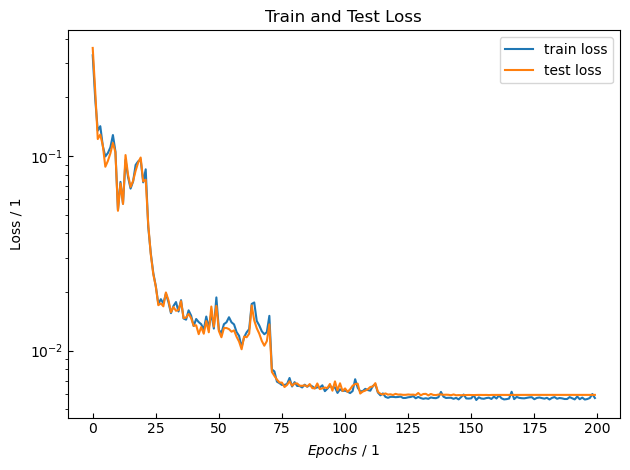

In [10]:
fig,ax = plt.subplots()
#fig.figsize=(12, 8)
ax.semilogy(train_loss, label='train loss')
ax.semilogy(test_loss, label='test loss')
plt.title("Train and Test Loss")
ax.set(xlabel = '$Epochs$ / 1', ylabel = 'Loss / 1') #Beschriftung Achsen; Kursiv durch $$; Index durch _{}
ax.tick_params(direction = 'in') #, length = 20, width = 3)

plt.legend()
plt.tight_layout()
plt.show()

In [11]:
#### Exportieren der Lernkurven zur Auswertung

In [12]:
np.savez('data/models/hyperparams/loss_005_008.npz', train_loss = train_loss, test_loss = test_loss)

#### Parity Plot

Training Dataset: R^2(H2) = 0.9998029011873066 , R^2(NH3) = 0.9994899813939689
Test Dataset: R^2(H2) = 0.9999047763495696 , R^2(NH3) = 0.9997926839838898
Max Error Training: |x_H2 - x_H2,pred| = 0.054472539837078726 , |x_NH3 - x_NH3,pred| = 0.034507849974621
Max Error Test: |x_H2 - x_H2,pred| = 0.009788722779222603 , |x_NH3 - x_NH3,pred| = 0.013770140789356927


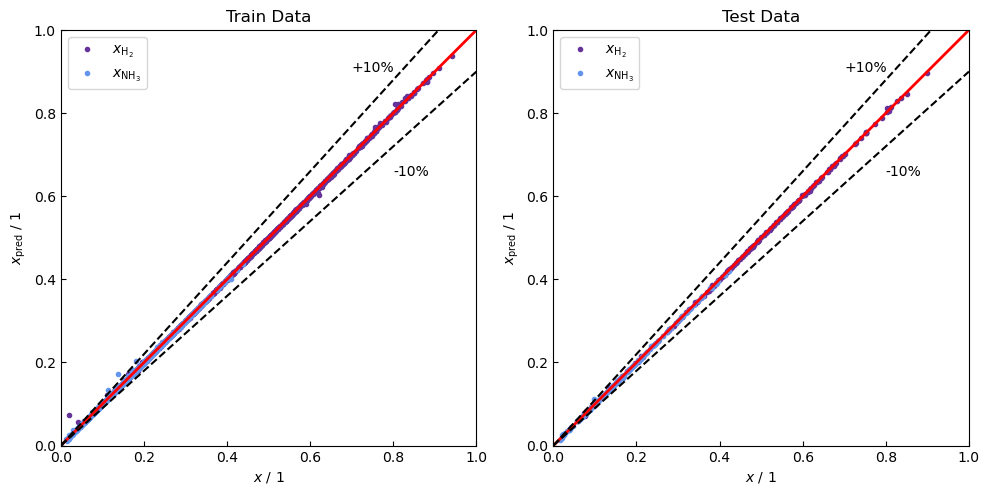

In [13]:
x_H2_real_norm = []
x_H2_pred_norm = []
x_NH3_real_norm = []
x_NH3_pred_norm = []
for (X,y) in train_dataloader:
    x_H2_real_norm = np.append(x_H2_real_norm, y[:,0].numpy())
    x_NH3_real_norm = np.append(x_NH3_real_norm, y[:,1].numpy())
    help_x_H2,help_x_NH3 = (net(X).detach().numpy()).T
    x_H2_pred_norm = np.append(x_H2_pred_norm, help_x_H2)
    x_NH3_pred_norm = np.append(x_NH3_pred_norm, help_x_NH3)

x_H2_real_test_norm = []
x_H2_pred_test_norm = []
x_NH3_real_test_norm = []
x_NH3_pred_test_norm = []
for (X,y) in test_dataloader:
    x_H2_real_test_norm = np.append(x_H2_real_test_norm, y[:,0].numpy())
    x_NH3_real_test_norm = np.append(x_NH3_real_test_norm, y[:,1].numpy())
    help_x_H2,help_x_NH3 = (net(X).detach().numpy()).T
    x_H2_pred_test_norm = np.append(x_H2_pred_test_norm, help_x_H2)
    x_NH3_pred_test_norm = np.append(x_NH3_pred_test_norm, help_x_NH3)

x_H2_real = x_H2_real_norm * std_out[0].numpy() + mean_out[0].numpy()
x_H2_pred = x_H2_pred_norm * std_out[0].numpy() + mean_out[0].numpy()
x_NH3_real = x_NH3_real_norm * std_out[1].numpy() + mean_out[1].numpy()
x_NH3_pred = x_NH3_pred_norm * std_out[1].numpy() + mean_out[1].numpy()

x_H2_real_test = x_H2_real_test_norm * std_out[0].numpy() + mean_out[0].numpy()
x_H2_pred_test = x_H2_pred_test_norm * std_out[0].numpy() + mean_out[0].numpy()
x_NH3_real_test = x_NH3_real_test_norm * std_out[1].numpy() + mean_out[1].numpy()
x_NH3_pred_test = x_NH3_pred_test_norm * std_out[1].numpy() + mean_out[1].numpy()

print('Training Dataset: R^2(H2) =', r2(x_H2_real,x_H2_pred), ', R^2(NH3) =', r2(x_NH3_real,x_NH3_pred))
print('Test Dataset: R^2(H2) =', r2(x_H2_real_test,x_H2_pred_test), ', R^2(NH3) =', r2(x_NH3_real_test,x_NH3_pred_test))
print('Max Error Training: |x_H2 - x_H2,pred| =', max_error(x_H2_real, x_H2_pred), ', |x_NH3 - x_NH3,pred| =', max_error(x_NH3_real, x_NH3_pred))
print('Max Error Test: |x_H2 - x_H2,pred| =', max_error(x_H2_real_test, x_H2_pred_test), ', |x_NH3 - x_NH3,pred| =', max_error(x_NH3_real_test, x_NH3_pred_test))

# find the boundaries of X and Y values
bounds = (0,1)

fig,ax = plt.subplots(1,2, figsize =(10,10))

# # Reset the limits
# ax[0] = plt.gca()
ax[0].set_xlim(bounds)
ax[0].set_ylim(bounds)
# Ensure the aspect ratio is square
ax[0].set_aspect("equal", adjustable="box")

ax[0].plot(x_H2_real, x_H2_pred, '.', color ='rebeccapurple', label = '$x\mathregular{_{H_2}}$')
ax[0].plot(x_NH3_real, x_NH3_pred, '.', color ='cornflowerblue', label = '$x\mathregular{_{NH_3}}$')
ax[0].plot([0, 1], [0, 1], "r-",lw=2 ,transform=ax[0].transAxes)
ax[0].plot([bounds[0],bounds[1]], [bounds[0] * 1.1, bounds[1] * 1.1], "k--") # Error line
ax[0].plot([bounds[0],bounds[1]], [bounds[0] * 0.9, bounds[1] * 0.9], "k--") # Error line
ax[0].text(0.7, 0.9, '+10%')
ax[0].text(0.8, 0.65, '-10%')
ax[0].set(xlabel = '$x$ / 1', ylabel = '$x\mathregular{_{pred}}$ / 1')
ax[0].tick_params(direction = 'in') #, length = 20, width = 3)
ax[0].set_title('Train Data')
ax[0].legend()
#ax[0].legend(['$\\mathregular{R^2}$ = ', r2(xi_real,xi_pred)], markerscale=0)

# Reset the limits
#ax[1] = plt.gca()
ax[1].set_xlim(bounds)
ax[1].set_ylim(bounds)
# Ensure the aspect ratio is square
ax[1].set_aspect("equal", adjustable="box")

ax[1].plot(x_H2_real_test, x_H2_pred_test, '.', color ='rebeccapurple', label = '$x\mathregular{_{H_2}}$')
ax[1].plot(x_NH3_real_test, x_NH3_pred_test, '.', color ='cornflowerblue', label = '$x\mathregular{_{NH_3}}$')
ax[1].plot([0, 1], [0, 1], "r-",lw=2 ,transform=ax[1].transAxes)
ax[1].plot([bounds[0],bounds[1]], [bounds[0] * 1.1, bounds[1] * 1.1], "k--") # Error line
ax[1].plot([bounds[0],bounds[1]], [bounds[0] * 0.9, bounds[1] * 0.9], "k--") # Error line
ax[1].text(0.7, 0.9, '+10%')
ax[1].text(0.8, 0.65, '-10%')
ax[1].set(xlabel = '$x$ / 1', ylabel = '$x\mathregular{_{pred}}$ / 1')
ax[1].tick_params(direction = 'in') #, length = 20, width = 3)
ax[1].set_title('Test Data')
ax[1].legend()


#plt.legend()
#fig.suptitle("Parity Plot")
plt.tight_layout()
plt.show()

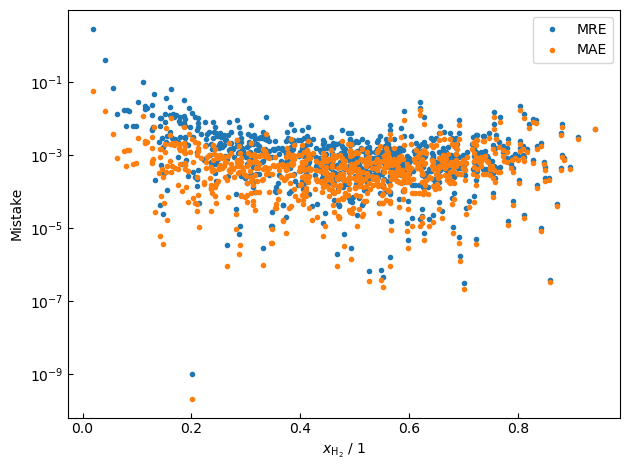

In [14]:
fig,ax = plt.subplots()
ax.semilogy(x_H2_real, abs((x_H2_pred - x_H2_real) / x_H2_real), '.', label = 'MRE')
ax.semilogy(x_H2_real, abs(x_H2_real-x_H2_pred), '.', label = 'MAE')
ax.set(xlabel = '$x \mathregular{_{H_2}}$ / 1', ylabel = 'Mistake')
ax.tick_params(direction = 'in') #, length = 20, width = 3)

plt.legend()
plt.tight_layout()
plt.show()

#### Plot Fehler vs Epoch

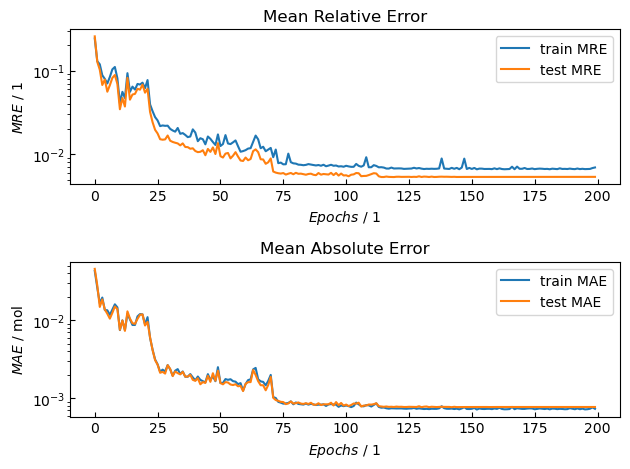

In [15]:
fig,ax = plt.subplots(2)
#fig.figsize=(12, 8)
ax[0].semilogy(train_MRE, label='train MRE')
ax[0].semilogy(test_MRE, label='test MRE')
ax[0].set_title("Mean Relative Error")
ax[0].set(xlabel = '$Epochs$ / 1', ylabel = '$MRE$ / 1') #Beschriftung Achsen; Kursiv durch $$; Index durch _{}
ax[0].tick_params(direction = 'in') #, length = 20, width = 3)
ax[0].legend()

ax[1].semilogy(train_MAE, label='train MAE')
ax[1].semilogy(test_MAE, label='test MAE')
ax[1].set_title("Mean Absolute Error")
ax[1].set(xlabel = '$Epochs$ / 1', ylabel = '$MAE$ / mol') #Beschriftung Achsen; Kursiv durch $$; Index durch _{}
ax[1].tick_params(direction = 'in') #, length = 20, width = 3)
ax[1].legend()

plt.tight_layout()
plt.show()

#### Plot Loss vs Variable Properties

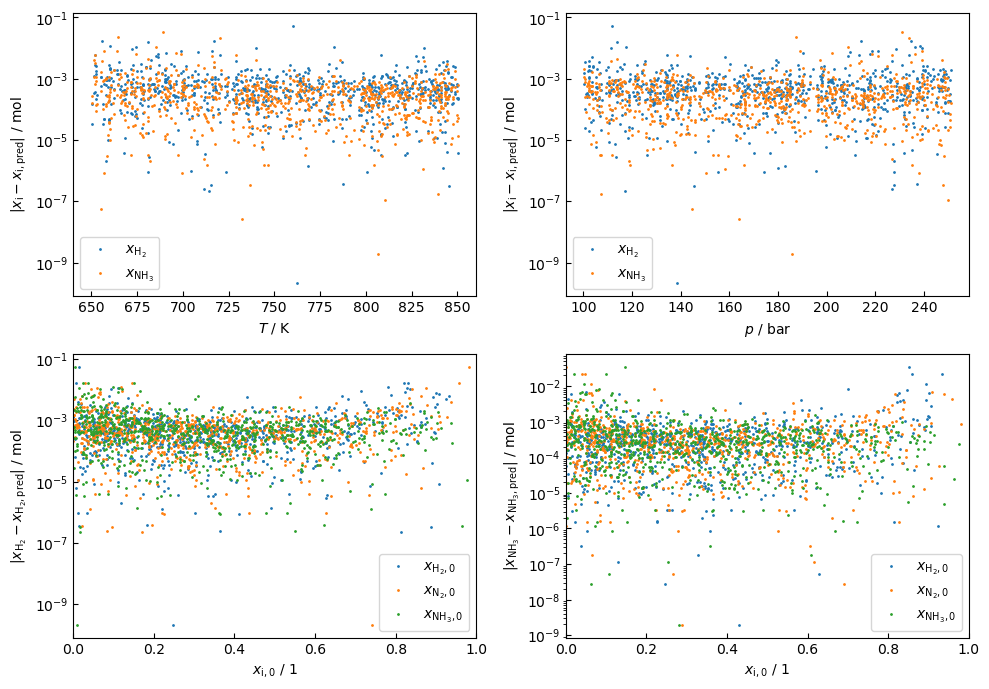

In [16]:
# mistake_H2 = []
# mistake_NH3 = []
x_H2_pred_norm = []
x_NH3_pred_norm = []
x_H2_real_norm = []
x_NH3_real_norm = []
param_T_norm = []
param_p_norm = []
param_x_H2_0_norm = []
param_x_N2_0_norm = []
param_x_NH3_0_norm = []
for X,y in train_dataloader:
#     help_mistake_H2, help_mistake_NH3 = (abs(y - net(X).detach().numpy())).T
#     mistake_H2 = np.append(mistake_H2, help_mistake_H2)
#     mistake_NH3 = np.append(mistake_NH3, help_mistake_NH3
    help_pred = net(X).detach().numpy()
    x_H2_pred_norm = np.append(x_H2_pred_norm, help_pred[:,0])
    x_NH3_pred_norm = np.append(x_NH3_pred_norm, help_pred[:,1])
    help_real = y.detach().numpy()
    x_H2_real_norm = np.append(x_H2_real_norm, help_real[:,0])
    x_NH3_real_norm = np.append(x_NH3_real_norm, help_real[:,1])
    param_T_norm = np.append(param_T_norm, X[:,0])
    param_p_norm = np.append(param_p_norm, X[:,1])
    param_x_H2_0_norm = np.append(param_x_H2_0_norm, X[:,2])
    param_x_N2_0_norm = np.append(param_x_N2_0_norm, X[:,3])
    param_x_NH3_0_norm = np.append(param_x_NH3_0_norm, X[:,4])

# print('x_H2:', x_H2_real_norm) #, x_H2_real_norm.dtype())
# print('x_H2_pred:', x_H2_pred_norm)
x_H2_pred = x_H2_pred_norm * std_out[0].numpy() + mean_out[0].numpy()
x_H2_real = x_H2_real_norm * std_out[0].numpy() + mean_out[0].numpy()
x_NH3_pred = x_NH3_pred_norm * std_out[1].numpy() + mean_out[1].numpy()
x_NH3_real = x_NH3_real_norm * std_out[1].numpy() + mean_out[1].numpy()

mistake_H2 = abs(x_H2_real - x_H2_pred)
mistake_NH3 = abs(x_NH3_real - x_NH3_pred)

param_T = param_T_norm * std_in[0].numpy() + mean_in[0].numpy()
param_p = param_p_norm * std_in[1].numpy() + mean_in[1].numpy()
param_x_H2_0 = param_x_H2_0_norm * std_in[2].numpy() + mean_in[2].numpy()
param_x_N2_0 = param_x_N2_0_norm * std_in[3].numpy() + mean_in[3].numpy()
param_x_NH3_0 = param_x_NH3_0_norm * std_in[4].numpy() + mean_in[4].numpy()

# print('T:', param_T[0])
# print(len(param_T))
# print(param_T[0])

fig,ax = plt.subplots(2,2, figsize = (10, 7)) #gridspec_kw={'width_ratios': [1,1,1,1]})

ax[0,0].semilogy(param_T, mistake_H2, '.', markersize = 2, label = '$x\mathregular{_{H_2}}$')
ax[0,0].semilogy(param_T, mistake_NH3, '.', markersize = 2, label = '$x\mathregular{_{NH_3}}$')
ax[0,0].set(xlabel = '$T$ / K', ylabel = '|$x\mathregular{_i} - x\mathregular{_{i,pred}}$| / mol')
ax[0,0].tick_params(direction = 'in') #, length = 20, width = 3)
ax[0,0].legend()

ax[0,1].semilogy(param_p, mistake_H2, '.', markersize = 2, label = '$x\mathregular{_{H_2}}$')
ax[0,1].semilogy(param_p, mistake_NH3, '.', markersize = 2, label = '$x\mathregular{_{NH_3}}$')
ax[0,1].set(xlabel = '$p$ / bar', ylabel = '|$x\mathregular{_i} - x\mathregular{_{i,pred}}$| / mol')
ax[0,1].tick_params(direction = 'in') #, length = 20, width = 3)
ax[0,1].legend()

ax[1,0].semilogy(param_x_H2_0, mistake_H2, '.', markersize = 2, label = '$x\mathregular{_{H_2, 0}}$')
ax[1,0].semilogy(param_x_N2_0, mistake_H2, '.', markersize = 2, label = '$x\mathregular{_{N_2, 0}}$')
ax[1,0].semilogy(param_x_NH3_0, mistake_H2, '.', markersize = 2, label = '$x\mathregular{_{NH_3, 0}}$')
ax[1,0].set(xlabel = '$x\mathregular{_{i,0}}$ / 1', ylabel = '|$x\mathregular{_{H_2}} - x\mathregular{_{H_2,pred}}$| / mol')
ax[1,0].tick_params(direction = 'in') #, length = 20, width = 3)
ax[1,0].set(xlim = (0,1))
ax[1,0].legend()

ax[1,1].semilogy(param_x_H2_0, mistake_NH3, '.', markersize = 2, label = '$x\mathregular{_{H_2, 0}}$')
ax[1,1].semilogy(param_x_N2_0, mistake_NH3, '.', markersize = 2, label = '$x\mathregular{_{N_2, 0}}$')
ax[1,1].semilogy(param_x_NH3_0, mistake_NH3, '.', markersize = 2, label = '$x\mathregular{_{NH_3, 0}}$')
ax[1,1].set(xlabel = '$x\mathregular{_{i,0}}$ / 1', ylabel = '|$x\mathregular{_{NH_3}} - x\mathregular{_{NH_3,pred}}$| / mol')
ax[1,1].tick_params(direction = 'in') #, length = 20, width = 3)
ax[1,1].set(xlim = (0,1))
ax[1,1].legend()

plt.tight_layout()
plt.show()

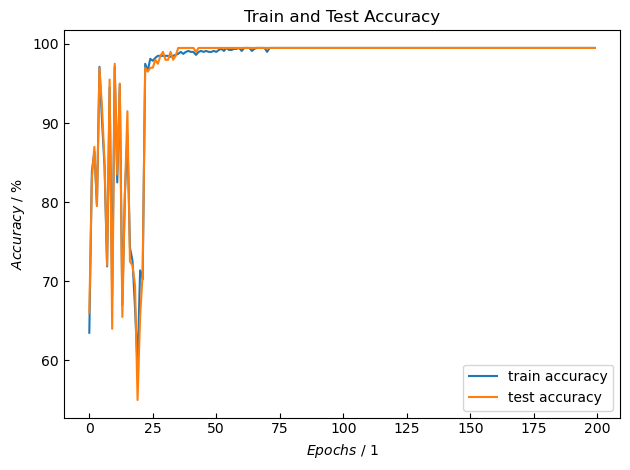

In [17]:
fig,ax = plt.subplots()
#fig.figsize=(12, 8)
ax.plot(train_accuracy, label='train accuracy')
ax.plot(test_accuracy, label='test accuracy')
plt.title("Train and Test Accuracy")
ax.set(xlabel = '$Epochs$ / 1', ylabel = '$Accuracy$ / %') #Beschriftung Achsen; Kursiv durch $$; Index durch _{}
ax.tick_params(direction = 'in') #, length = 20, width = 3)

plt.legend()
plt.tight_layout()
plt.show()

#### Debugging Hilfe

In [18]:
# Anzeigen aller Input X und Output y Daten
for (X,y) in train_dataloader:
    print(X)
    print(y)
    print(net(X))
    break

tensor([[ 1.4926, -0.6412, -0.3385, -0.1537,  0.4893],
        [-1.2683, -1.0797,  0.3031, -0.6516,  0.3685],
        [-0.3177,  0.9944, -1.2310,  0.8198,  0.3702],
        [-1.0719,  1.2129,  0.6992, -0.4757, -0.2001],
        [-1.6445,  1.6613, -1.3740,  0.8788,  0.4502],
        [-0.2185,  0.1331, -0.0101,  1.1138, -1.1284],
        [ 0.9347,  0.1857, -1.0135,  1.3048, -0.3389],
        [ 1.2939,  0.5117, -0.6523, -0.2847,  0.9312],
        [ 0.1501, -0.4753, -1.2199,  0.4591,  0.7280],
        [ 0.9407, -0.1802,  1.4081, -0.7077, -0.6585],
        [-0.6652,  0.2186,  1.1691,  0.1781, -1.3293],
        [ 1.0665,  1.3337, -1.3049, -1.0487,  2.3525],
        [-0.4461, -1.2031, -1.4157,  2.1154, -0.7728],
        [-1.1962, -0.8370, -0.9280, -0.9089,  1.8397],
        [ 0.8399, -0.7694,  1.4998, -0.3167, -1.1482],
        [ 0.1795, -1.2355,  0.0510,  1.0410, -1.1140],
        [ 1.0531, -0.6794,  0.0797, -0.3367,  0.2659],
        [ 0.9053, -0.4712, -0.8368,  1.2163, -0.4219],
        [ 

#### Einblick in Netzwerk

In [19]:
list(net.parameters()) # zeigt weights, biases, ...

[Parameter containing:
 tensor([[ 1.9729e-01, -4.1267e-02,  4.3790e-01, -2.5237e-02,  2.7998e-01],
         [ 6.2405e-02,  1.5001e-01, -2.4999e-01,  2.9803e-01, -1.5091e-01],
         [-8.4595e-02,  1.8660e-01,  1.3648e-02, -3.1145e-01, -5.2794e-02],
         [-2.0384e-01,  2.3043e-01,  1.3922e-01, -3.3403e-01, -2.1538e-01],
         [-1.2887e-01, -1.2700e-01,  3.8422e-01, -4.2556e-02,  2.7610e-01],
         [-3.6491e-02, -2.3794e-01,  7.0120e-02, -2.5467e-01, -8.6244e-02],
         [ 7.9255e-02,  1.4859e-01,  1.4280e-03,  2.4736e-01, -4.8342e-02],
         [-2.0260e-01,  1.4688e-03, -4.7724e-02,  3.1417e-01, -6.3919e-02],
         [ 3.4158e-02, -6.7495e-02, -2.2097e-01,  1.4573e-01, -7.8714e-02],
         [-8.4877e-02,  3.0305e-01, -3.4134e-01,  9.9272e-02, -1.1906e-01],
         [-9.2115e-02, -2.3856e-01,  3.9712e-02,  3.3601e-01,  2.2359e-01],
         [ 3.8427e-02, -3.3119e-02, -1.4962e-02, -3.5441e-01, -1.4237e-01],
         [ 4.1252e-02,  3.5767e-02, -4.7811e-02,  1.2589e-01, -1.

In [20]:
X = torch.rand((2,5))
print(X)
print(net(X))

tensor([[0.8596, 0.3628, 0.7192, 0.0358, 0.1340],
        [0.4617, 0.9489, 0.7374, 0.5158, 0.3095]])
tensor([[ 0.4691, -0.3296],
        [-0.0086,  0.0860]], grad_fn=<AddmmBackward0>)


In [21]:
Lnorm = nn.LayerNorm(5)
Bnorm = nn.BatchNorm1d(5)

In [22]:
for (X,y) in train_dataloader:
    print(X)
    #print(y.reshape((-1,1)))
    print(Bnorm(X).mean(dim=0))
    print(Bnorm(X))
    print(Lnorm(X))
    print((Lnorm(X.permute(0,2,1))).permute(0,2,1))
    print(Lnorm(X).mean(dim=0))
    print(Lnorm(X).mean(dim=1))


    break

tensor([[ 0.1362, -0.0201,  0.9955,  0.0053, -0.9823],
        [ 1.5870,  1.2557, -0.4148, -0.3719,  0.7872],
        [-0.4430,  0.0322,  1.7329, -1.0154, -0.6628],
        [ 0.4524, -0.2129, -0.8758,  0.6007,  0.2455],
        [ 0.5499, -1.6670,  1.4947, -0.8963, -0.5508],
        [ 1.1961, -0.2350,  1.6416, -1.1335, -0.4525],
        [ 0.3890, -1.1354,  0.8459, -1.0446,  0.2375],
        [-0.0706,  0.5163, -1.1562,  1.7878, -0.6926],
        [-0.9163,  0.5315,  1.1628, -1.2732,  0.1602],
        [ 1.1893, -0.4103, -0.8378,  2.0083, -1.2305],
        [ 1.5547,  1.3097, -0.3148,  1.4720, -1.1955],
        [ 0.6476,  1.5108,  1.1375, -1.3260,  0.2389],
        [-1.2474, -1.0619, -0.8580,  1.4754, -0.6659],
        [-1.2812, -1.4891,  1.7154, -1.1615, -0.4963],
        [ 1.0787,  1.0912,  0.0372, -1.3056,  1.2979],
        [ 0.1908, -0.5560, -0.1400, -0.8628,  1.0192],
        [-0.5906, -1.1820,  0.5615, -0.0723, -0.4772],
        [ 1.5312,  1.1676,  0.7182, -1.0581,  0.3766],
        [-

RuntimeError: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 2 is not equal to len(dims) = 3

#### Histogramme Verteilung von $xi$ und $x{_i}$

In [ ]:
#plt.hist(xi)
plt.hist(x_0[:,0],bins=100)
plt.hist(x_0[:,1],bins=100)

plt.show()